Домашнее задание

# I part

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

Скачайте текст войны и мир (ссылка на github и гугл диск).  
Очистите его, оставив только русские буквы и символы пробела.  

In [2]:
text = str()

for i in range(1,5): 
    with open(f'../AMLHW_15_mrf/war_and_peace/tom_{i}.txt', 'r', encoding='utf-8') as f:
        text += f.read().lower()
text = re.sub(r'[^а-яё ]','', text)

Постройте матрицу переходных вероятностей.  

In [3]:
RUSSIAN_WITH_SPACE = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(RUSSIAN_WITH_SPACE)}

In [4]:
probabilities = np.zeros((len(RUSSIAN_WITH_SPACE), len(RUSSIAN_WITH_SPACE)))

In [5]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [6]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [7]:
df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN_WITH_SPACE), columns=(c for c in RUSSIAN_WITH_SPACE))

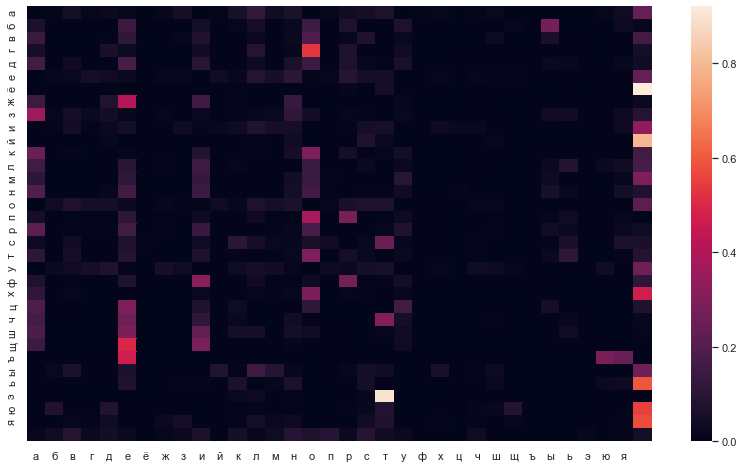

In [8]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р;  

In [9]:
start = POS['п']
end = POS['р']
prior = 1. / len(RUSSIAN_WITH_SPACE)
for c in RUSSIAN_WITH_SPACE:
    for s_c in RUSSIAN_WITH_SPACE:
        proba = prior * probabilities[start, POS[c]] * \
                    probabilities[POS[c], POS[s_c]] * probabilities[POS[s_c], end]
        if proba > 0.00001:
            print(''.join(['п', c, s_c, 'р']), proba)

пегр 1.1112317321777153e-05
пепр 1.2112841989055931e-05
пе р 1.854375468700912e-05
побр 2.9433951560885752e-05
повр 1.4354422427861556e-05
погр 3.84767361012238e-05
подр 3.817691323612121e-05
поер 2.580608653130366e-05
попр 4.141720191311109e-05
потр 4.228590463090975e-05
по р 6.000469108869473e-05
прар 7.43645140131875e-05
прер 0.00011985973476310438
прор 9.147367042682817e-05
прур 1.5378847130707658e-05
пь р 1.570248682561254e-05


Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов

In [20]:
s = []
start = "б"
s.append(start)
length = 8
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(RUSSIAN_WITH_SPACE), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

бивилсыез


# II

Выберите ряд и оцените его через HMM. Попробуйте "построить" (через среднее каждой компоненты) наивный прогноз ряда.

In [11]:
series = pd.read_excel('Qlik.xlsx').drop('Sales Qty', axis=1)
series.drop(series.tail(1).index,inplace=True)

In [12]:
series['Invoice Date'] = pd.to_datetime(series['Invoice Date'], errors='coerce')

In [13]:
series = series.loc[:,'Sales']

In [14]:
from hmmlearn.hmm import GaussianHMM

In [15]:
values = series.values.reshape(-1,1)

In [16]:
best_score = np.inf
for n in range(1, 15):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))
    if np.abs(model.score(values)) <= best_score:
        best_score = np.abs(model.score(values))
        best_n = n

1 -8198.359810901178
2 -8033.963776683712
3 -7995.257925217293
4 -7984.076675620908
5 -7957.784996829665
6 -7944.326117533439
7 -7935.97097477555
8 -7925.820970633937
9 -7911.688474647097
10 -7902.658664908946
11 -7884.777017970775
12 -7880.289008714649
13 -7873.485427234082
14 -7856.603211870743


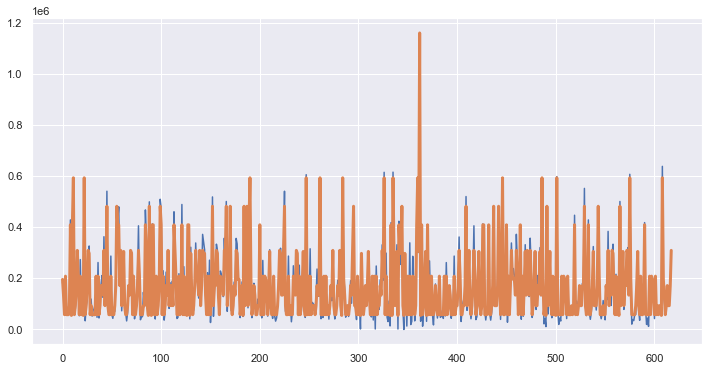

In [17]:
model = GaussianHMM(n_components=best_n,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)